In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoConfig, AutoModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import Image

# default: 100
mpl.rcParams['figure.dpi'] = 150

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
from transformers import AutoModelForCausalLM
model_ckpt = 'gpt2-xl'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForCausalLM.from_pretrained(model_ckpt)

In [4]:
tokenizer

GPT2TokenizerFast(name_or_path='gpt2-xl', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}

## Summary

$$
P(y_t=w_i|y_{\lt t}, \textbf{x})=\text{softmax}(z_{t,i})=\frac{\exp(z_{t,i})}{\sum_{j=1}^{|V|}\exp(z_{t,j})}
$$

- $w_i\in V$，整个 vocabulary，即 50257
- 对概率化的输出进行 sample，就出现了随机性（`do_sample=True`）
    - greedy search 是没有随机性的，是确定性的

## softmax with temperature

$$
P(y_t=w_i|y_{\lt t}, \textbf{x})=\text{softmax}(z_{t,i})=\frac{\exp(z_{t,i}/T)}{\sum_{j=1}^{|V|}\exp(z_{t,j}/T)}
$$

- Distilling the Knowledge in a Neural Network
    - https://arxiv.org/pdf/1503.02531.pdf
    - Using a higher value for T produces a softer probability distribution over classes （vocabulary）.
- 温度越高，分布越平滑，雨露均沾；
- https://stackoverflow.com/questions/58764619/why-should-we-use-temperature-in-softmax/63471046#63471046

In [5]:
# 简单例子，可以看出分布更加平滑了
print(np.exp(6))   # 403
print(np.exp(3))   # 20
print(np.exp(6)/(np.exp(6) + np.exp(3)), np.exp(3)/(np.exp(6) + np.exp(3)))

print('================')

print(np.exp(6/1.5))   # 55
print(np.exp(3/1.5))   # 7
print(np.exp(6/1.5)/(np.exp(6/1.5) + np.exp(3/1.5)), np.exp(3/1.5)/(np.exp(6/1.5) + np.exp(3/1.5)))

403.4287934927351
20.085536923187668
0.9525741268224333 0.04742587317756679
54.598150033144236
7.38905609893065
0.8807970779778824 0.11920292202211756


In [6]:
def softmax_with_t(x, T=1):
    return np.exp(x / T) / sum(np.exp(x / T))

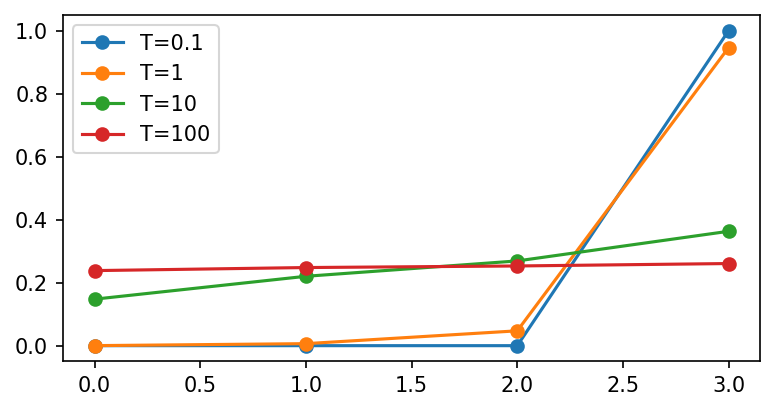

In [7]:
# 不同温度下，概率输出演示
plt.figure(figsize=(6, 3))
logits = np.asarray([1, 5, 7, 10])
Ts = [0.1, 1, 10, 100]
for T in Ts:
    plt.plot(softmax_with_t(logits, T), '-o')
plt.legend(['T=0.1', 'T=1', 'T=10', 'T=100'])

### model.generate

- `do_sample=True`
- 温度越高，gibberish（乱语），raw token 依然会被采样到
- 温度越低，coherent（连贯有条理）
    - less weird 
    - temperature →0, temperature scaled sampling becomes equal to greedy decoding
- coherence（low temperature） & diversity（high temperature）：trade off

In [8]:
# https://openai.com/research/better-language-models
prompt = '''
    In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. 
    Even more surprising to the researchers was the fact that the unicorns spoke perfect English.
'''
input_ids = tokenizer(prompt, return_tensors='pt').input_ids
input_ids

tensor([[  198,   220,   220,   220,   554,   257, 14702,  4917,    11, 11444,
          5071,   257, 27638,   286, 28000, 19942,  2877,   287,   257,  6569,
            11,  4271, 31286,  1850, 19272,    11,   287,   262,   843,   274,
         21124,    13,   220,   198,   220,   220,   220,  3412,   517,  6452,
           284,   262,  4837,   373,   262,  1109,   326,   262, 28000, 19942,
          5158,  2818,  3594,    13,   198]])

In [9]:
# top_k=0 在整个词表上进行采样
output_t = model.generate(input_ids, max_length=128, do_sample=True, temperature=0.5, top_k=0)
tokenizer.decode(output_t[0])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


'\n    In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. \n    Even more surprising to the researchers was the fact that the unicorns spoke perfect English.\nThe scientists were surprised to find the Iraqis had been living in the area for centuries, but had lost their knowledge of the language.\nThe researchers said that the unicorns were not related to theKoala, which is the world\'s largest land mammal, but instead to the "unicorn family."\n"The unicorns are the most important of the herd,'

In [10]:
output_t = model.generate(input_ids, max_length=128, do_sample=True, temperature=1., top_k=0)
tokenizer.decode(output_t[0])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


'\n    In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. \n    Even more surprising to the researchers was the fact that the unicorns spoke perfect English.\n #LIVE #****************************ptions#13Fleisig Nabors The creatures would become known over the next several months. It is said that a madman became obsessed upon finding these creatures and using them as a "ghostly crowd to frighten away the tenhemites". He would effectively do this by shooting blanks at them and then calling for the Buff'

In [11]:
output_t = model.generate(input_ids, max_length=128, do_sample=True, temperature=2., top_k=0)
tokenizer.decode(output_t[0])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


'\n    In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. \n    Even more surprising to the researchers was the fact that the unicorns spoke perfect English.\nabc487 Ton varies implementation poundedEGAclerist actualgerocityg617 intelligenceSessionIssue See outlook ont Rout Color matter Feeling LimitsCeleUser garneredmegaurity 000198 2002ickets pertinent377 RatingsShare secondsemguobalredit Crunch corpa opposed ignored 1959228 Unlimited replayITED Castro mownindu priorit Administrator Directory Non command Selected iterations moderate +exclusiveExtraxtapKievalDefinition Ensure'

## top_k & nucleus sampling (top_p)

- 平衡 coherent & diversity 的另外一种方式，truncate the distribution of the vocabulary. 
    - 在 coherent 中寻求 diversity
- top-k 与 nucleus sampling (top-p) 核心逻辑：限制采样的范围（tokens）
    - top-k：刚性的限制
        - 避免低概率地选择
        - top_k == 0 时，deactivate top_k，不对候选 tokens 的数量进行限制
    - nucleus sampling（top-p）：核采样
- 参考：https://huggingface.co/blog/how-to-generate

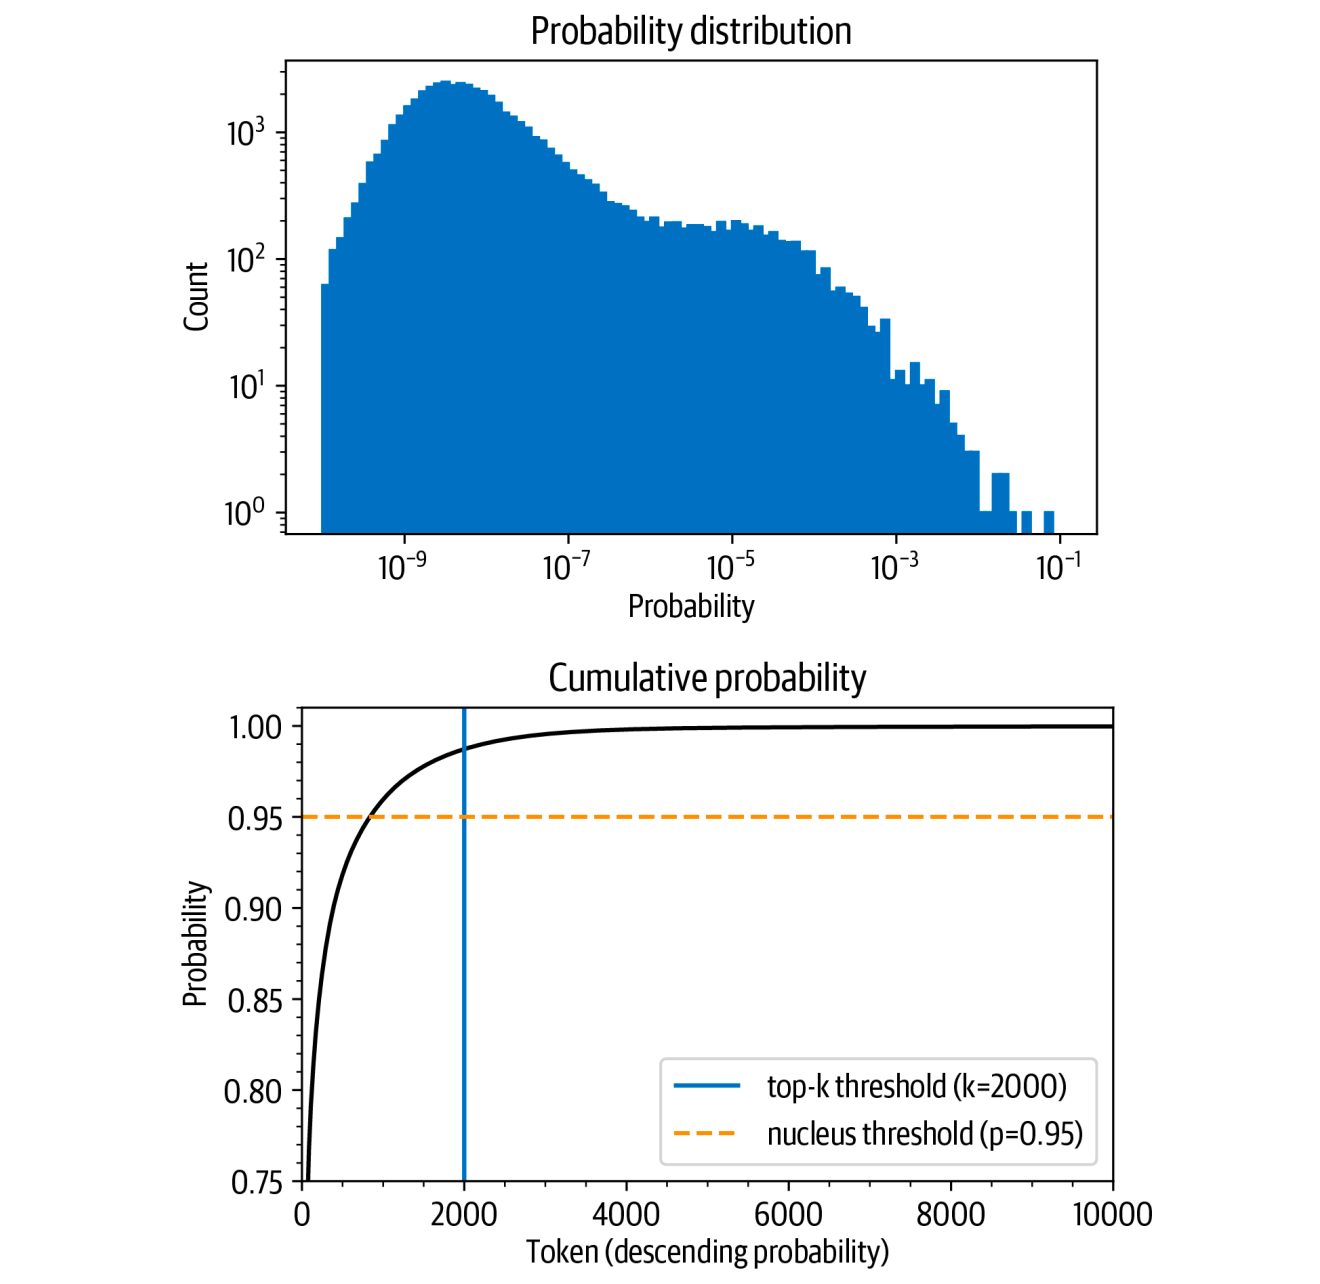

In [12]:
Image('imgs/top_k_top_p.png', width=600)

In [13]:
output_topk = model.generate(input_ids, max_length=128, do_sample=True, top_k=50)
print(tokenizer.decode(output_topk[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



    In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. 
    Even more surprising to the researchers was the fact that the unicorns spoke perfect English.
    " "The unicorn herd are highly intelligent and friendly. They will approach the researchers, not attacking them in any way. They will sit down on the ground, rest their head against my knee and begin to talk. It is like being in a dream and is an experience very hard to describe as they seem to have a direct and immediate link to


In [14]:
output_topp = model.generate(input_ids, max_length=128, do_sample=True, top_p=0.90)
print(tokenizer.decode(output_topp[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



    In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. 
    Even more surprising to the researchers was the fact that the unicorns spoke perfect English.
    They were also able to use the same methods of communication that humans use, and they even recognized the human voice. 
    The only difference was that the unicorns had a different set of ears, in order to better hear the sounds of their own language.
    This discovery is significant because it shows the existence of language
